# Preface

If you were to generate every single possible permutation of pixels in an image of a given size and color depth, then you would in your possession _every_ image of that size and color depth that there was _or ever will be_.

This is really cool!

Imagine for example digging into that pandora's box with some machine learning to try to identity objects..

Could you dig out images from the past?

_From the future?_

Is this where technology and philosophy meet.. again?

# Calculating the number of permutations

The images would need to be large enough that you'd be able to discern the details in their pixels, but not so large that the computational requirements exceed the resources available, so it'd be good to know up front what sort of numbers we're talking about.

The formula to determine the number of permutations is pretty simple:

In [1]:
def num_permutations(num_pixels, num_colors):
    return num_colors ** num_pixels

We can test this out, knowing that a 2x2 image with 2 colors has only 16 permutations:

In [2]:
num_permutations(2*2, 2)

16

Or with a slightly bigger image:

In [3]:
num_permutations(16*16, 2)

115792089237316195423570985008687907853269984665640564039457584007913129639936

Already we can see this is quite a lot of permutations for such a small image, which _is_ a problem, but we'll come back to that shortly.

# Generating pixel data

In [4]:
def get_pixel(index, pixel_index, num_pixels, num_colors):
    return int((index / (num_colors ** pixel_index)) % num_colors)

And we can test this out by querying the first couple of pixels of the second permutation of any size image, which will always be `1` and `0` respectively.

In [5]:
get_pixel(1, 0, 4, 2)

1

In [6]:
get_pixel(1, 1, 4, 2)

0

# Generating image data

In [7]:
def get_image(index, num_pixels, num_colors):
    return list(map(lambda i: get_pixel(index, i, num_pixels, num_colors), range(0, num_pixels)))

In [8]:
# Get the first image
get_image(0, 9, 2)

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [9]:
# Get the last image
get_image(num_permutations(9, 2) - 1, 9, 2)

[1, 1, 1, 1, 1, 1, 1, 1, 1]

# Generating an image

In [10]:
from PIL import Image

def generate_image(data, image_size, num_colors):
    image = Image.new('RGB', (image_size, image_size))
    
    for y in range(0, image_size - 1):
        for x in range(0, image_size - 1):
            color = int((255 / num_colors) * data[x + y])
            image.putpixel((x, y), (color, color, color))
    
    return image

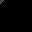

In [11]:
# Generate an image
image_size = 32
num_colors = 2

data = get_image(41239847293874, image_size * image_size, num_colors)

generate_image(data, image_size, num_colors)

# Cutting down computation

A problem starts to emerge as you increase the size of the image and color depth. A tiny image of just 32x32 pixels and 8 colors has an incredible number of permutations:

In [12]:
num_permutations(32*32, 8)

5809605995369958062859502533304574370686975176362895236661486152287203730997110225737336044533118407251326157754980517443990529594540047121662885672187032401032111639706440498844049850989051627200244765807041812394729680540024104827976584369381522292361208779044769892743225751738076979568811309579125511333093243519553784816306381580161860200247492568448150242515304449577187604136428738580990172551573934146255830366405915000869643732053218566832545291107903722831634138599586406690325959725187447169059540805012310209639011750748760017095360734234945757416272994856013308616958529958304677637019181594088528345061285863898271763457294883546638879554311615446446330199254382340016292057090751175533888161918987295591531536698701292267685465517437915790823154844634780260102891718032495396075041899485513811126977307478969074857043710716150121315922024556759241239013152919710956468406379442914941614357107914462567329693696

And if we stretch for something _almost_ usable, this happens:

In [13]:
num_permutations(256*256, 256)

2596370567831000776126596495726882827744734376348456046357365486775461052458820506291297794947214897395589962375459750509570675451859578206757876095315086972628069617519314963778665833678900404121705364193859219828740945594078483094487744347427003614453869400832764934146727909760782220949911951752445393548637492472548843954856699555287844348856931688787737593317801595120557431635074825832368278325452660764971865590642685979756491623782891282904220175034306289604187127398229160111193103541244596516086139292434238902991626429487128920556410965853850184271207914987931149710810413116032810081772199491011279531187259219612909610384274649448086565081971110049153972318816986368469388201312689583617524034449225373051957177306844938895021543176813548796637054467215745860294620927666189318667920117817866076104912042070024309736132352966492699030403748222810421116548012232637818046971624021534677022410164720419941224901208775719100490550206353773383348282516488364021076991161409962928780642354505